# Setting the values for constants
* inf: as a default distance to nodes
* time_threshold: threshold time for the rebuilding of the quantum link
* original_capacity: original capacity of the quantum link
* original_cost: cost of using the link
* Edge: create Edge object of the graph

In [1]:
# Importing packages
import os
from collections import deque, namedtuple
import time, random
from datetime import datetime
import heapq
import numpy

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Setting up logger
import logging, importlib
import time

In [3]:
inf = float('inf')
time_threshold = 10000
original_capacity = 1
original_cost = 1
long_link_cost = 1000
rebuild_probability = 0.25
number_of_nodes = 32

# Define the number of source destination pairs

In [10]:
number_of_source_destination_pairs = 70
number_of_samples = 1000

# Plotting the results

# The Graph class

In [13]:
#Helper functions
def dist(graph, start_node, end_node):
    return min(abs(start_node - end_node), len(graph.vertices) + start_node - end_node,
               abs(end_node - start_node), len(graph.vertices) - start_node + end_node)

def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def reduce_edges(edge_list:list):
    local_dictionary = {}
    local_list = []
    for (start, end, capacity) in edge_list:
        if (start, end) in local_dictionary:
            local_dictionary[(start, end)] += capacity
        else:
            local_dictionary[(start, end)] = capacity
    for edge, capacity in local_dictionary.items():
        local_list.append((edge[0], edge[1], capacity))
    return local_list

#Defining the classes

class Vertex:
    def __init__(self, vertex):
        self.name = vertex
        self.neighbours = {}

    # Storing the indices of neighbouring vertices
    def add_neighbour(self, neighbour, capacity=1):
        if neighbour not in self.neighbours:
            self.neighbours[neighbour] = capacity
        else:
            return False

    def add_neighbours(self, neighbours):
        for neighbour in neighbours:
            if isinstance(neighbour, tuple):
                self.add_neighbour(neighbour[0], neighbour[1])
            else:
                self.add_neighbour(neighbour)

    def __repr__(self):
        return str(self.neighbours)


class Graph:

    # Check that the arguments are valid
    # edges: list of edges awaited in the format of list(tuple(start_node, end_node, capacity))
    def __init__(self, edges:list =None, bidirectional = True):
        self.Vertices = {}
        self.bidirectional = bidirectional

        # Initializing graph based on edges
        if edges is not None:
            #wrong_edges = [i for i in edges if len(i) not in [2, 4]]
            #if wrong_edges:
            #    raise ValueError('Wrong edges data: %s', wrong_edges)

            # Adding bidirectional links
            for (start_node, end_node, capacity) in edges:

                # Adding onward link
                if start_node not in self.Vertices.keys():
                    self.Vertices[start_node] = Vertex(start_node)

                self.Vertices[start_node].add_neighbour(end_node, capacity)

                # Adding backward link
                if end_node not in self.Vertices.keys():
                    self.Vertices[end_node] = Vertex(end_node)

                self.Vertices[end_node].add_neighbour(start_node, capacity)
    @property
    def vertices(self):
        return self.Vertices

    def vertex(self, vertex):
        try:
            self.vertices[vertex]
        except:
            log.debug("No such start node found among the vertices.")
        return self.vertices[vertex]

    def edge(self, start_node, end_node):

        try:
            self.vertex(start_node).neighbours[end_node]
        except:
            log.debug("No such end node found among the vertices.")
        return self.vertices[start_node].neighbours[end_node]

    def add_vertex(self, vertex):
        if isinstance(vertex, Vertex):
            self.Vertices[vertex.name] = vertex.neighbours

    def add_vertices(self, vertices):
        for vertex in vertices:
            self.add_vertex(vertex)

    def add_edge(self, vertex_from, vertex_to):
        if isinstance(vertex_from, Vertex) and isinstance(vertex_to, Vertex):
            vertex_from.add_neighbour(vertex_to)
            if isinstance(vertex_from, Vertex) and isinstance(vertex_to, Vertex):
                self.Vertices[vertex_from.name] = vertex_from.neighbours
                self.Vertices[vertex_to.name] = vertex_to.neighbours

    def add_edges(self, edges):
        for edge in edges:
            self.add_edge(edge[0], edge[1])
    
    def add_capacity(self, start_node: int, end_node: int, capacity: int):
        try:
            self.vertices[start_node]
        except KeyError:
            log.debug("No such start node found among the vertices.")
        try:
            self.vertices[start_node].neighbours[end_node]
        except KeyError:
            log.debug("No such end node found among the vertices.")
        self.vertices[start_node].neighbours[end_node] += 1
        
    def get_edge_capacity(self, start_node, end_node):

        try:
            self.vertices[start_node]
        except KeyError:
            log.debug("No such start node found among the vertices.")
        try:
            self.vertices[start_node].neighbours[end_node]
        except KeyError:
            log.debug("No such end node found among the vertices.")
        return self.vertices[start_node].neighbours[end_node]
    
    def get_number_of_unavailable_virtual_links(self):
        number_of_zero_capacity_links = 0
        for x in self.vertices.keys():
            number_of_zero_capacity_links += sum([1 for x in self.vertices[x].neighbours.values() if x == 0])
        if self.bidirectional:
            return number_of_zero_capacity_links/2
        else:
            return number_of_zero_capacity_links
def traceback_path(target, parents):
    path = deque()
    while target:
        path.appendleft(target)
        target = parents[target]
    return path


class HeapEntry:
    def __init__(self, node, distance):
        self.node = node
        self.distance = distance

    def __lt__(self, other):
        return self.distance < other.distance

# Calculating tentative cost
            # Using hardcoded value of 1 as a cost (unique costs need to be stored for each edge)

            # Using different cost function if the capacity is 0 (cost is defined as 1000)
def weight(graph:Graph, start: int, end: int):
    if graph.get_edge_capacity(start, end) == 0:
        return long_link_cost * dist(graph, start, end)
    else:
        return original_cost

# The Dijkstra algorithm with a support for rebuilding the best next hop
def dijkstra(graph: Graph, start: int, finish: int) -> deque:
    open_nodes = [HeapEntry(start, 0.0)]
    closed_nodes = set()
    parents = {start: None}
    distance = {start: 0.0}

    while open_nodes:
        current = heapq.heappop(open_nodes).node

        if current is finish:
            return traceback_path(finish, parents)

        if current in closed_nodes:
            continue

        closed_nodes.add(current)

        # For every child of the current node (taking the neighbours)
        for child in graph.vertices[current].neighbours.keys():
            if child in closed_nodes:
                continue

            tentative_cost = distance[current] + weight(graph, current, child)
                
            if child not in distance.keys() or distance[child] > tentative_cost:
                distance[child] = tentative_cost
                parents[child] = current
                heap_entry = HeapEntry(child, tentative_cost)
                heapq.heappush(open_nodes, heap_entry)

# Graph definitions

### Graph 0 (on-demand ring), Graph 1 (ring with preshared links)

In [14]:
#-------------------
# Graph0
#-------------------

#Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
graph0 = [(x,x+1, 0) for x in range(1,number_of_nodes)] + [(number_of_nodes,1, 0)]

#-------------------
# Graph1
#-------------------

#Initiating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
graph1 = [(x,x+1,original_capacity) for x in range(1,number_of_nodes)] + [(number_of_nodes,1, original_capacity)]

#-------------------
# Graph2
#-------------------

#Initiating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
graph2 = [(x,x+1,original_capacity) for x in range(1,number_of_nodes)] + [(number_of_nodes,1, original_capacity)]

#Initiating the edges of 1) type: 1->3, 3->5, ... 31->1
#Odd number of nodes
graph2 = graph2 + [(x,x+2,original_capacity) for x in range(1,number_of_nodes+1)
             if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1]
    
#Even number of nodes
graph2 = graph2 + [(x,(x+2) % number_of_nodes, original_capacity) for x in range(1,number_of_nodes+1) if x % 2 == 1 and x < number_of_nodes
     and number_of_nodes % 2 == 0]

#-------------------
# Graph3
#-------------------

#Initiating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
graph3 = [(x,x+1, original_capacity) for x in range(1,number_of_nodes)] + [(number_of_nodes,1, original_capacity)]
    
#Initiating the edges of 1) type: 1->3, 3->5, ... 31->1
#Even number of nodes    
graph3 = graph3 + [(x,(x+2) % number_of_nodes, original_capacity) for x in range(1,number_of_nodes+1)
                                 if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 0]
#Odd number of nodes
graph3 = graph3 + [(x,x+2, original_capacity) for x in range(1,number_of_nodes+1)
             if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1]

#Initiating the edges of 2) type: 1->5, 5->9, ... 29->1
#Number of nodes have 0 as remainder for modulo 4 
graph3 = graph3 + [(x,x+4, original_capacity) for x in range(1,number_of_nodes-3)
                   if x % 4 == 1 and number_of_nodes % 4 == 0]

graph3 = graph3 + [(number_of_nodes-3,1, original_capacity) for x in range(1,2) if number_of_nodes % 4 == 0]

#-------------------
# Graph1 - equal edges
#-------------------

#Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
graph1_equal_edges = []
graph1_equal_edges = [(x,x+1,original_capacity) for x in range(1,number_of_nodes)] + [(number_of_nodes,1,original_capacity)]


#Iniating the edges of 1) type: 1->2, 3->4, ... 31->32
#Odd number of nodes
graph1_equal_edges = graph1_equal_edges + [(x,x+1,original_capacity) for x in range(1,number_of_nodes+1)
             if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1]
    
#Even number of nodes
graph1_equal_edges = graph1_equal_edges + [(x,(x+1) % (number_of_nodes+1),original_capacity) for x in range(1,number_of_nodes+1) if x % 2 == 1 and x < number_of_nodes
     and number_of_nodes % 2 == 0]


#Iniating the edges of 2) type: 1->2, 5->6, ... 29->30
#Number of nodes have 0 as remainder for modulo 4 
graph1_equal_edges = graph1_equal_edges + [(x,x+1,original_capacity) for x in range(1,number_of_nodes-3) if x % 4 == 1 and number_of_nodes % 4 == 0] + [(number_of_nodes-3,number_of_nodes-2,original_capacity)]

# Add up the multiple links:
graph1_equal_edges = reduce_edges(graph1_equal_edges)

#-------------------
# Graph2 - equal edges
#-------------------

#Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
graph2_equal_edges = [(x,x+1,original_capacity) for x in range(1,number_of_nodes)] + [(number_of_nodes,1,original_capacity)]

#Iniating the edges of 1) type: 1->3, 3->5, ... 31->1
#Odd number of nodes
graph2_equal_edges = graph2_equal_edges + [(x,x+2,original_capacity) for x in range(1,number_of_nodes+1)
             if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1]
    
#Even number of nodes
graph2_equal_edges = graph2_equal_edges + [(x,(x+2) % number_of_nodes,original_capacity) for x in range(1,number_of_nodes+1) if x % 2 == 1 and x < number_of_nodes
     and number_of_nodes % 2 == 0]

#Adding additional long links to equal out the missing links compared to graph3
#Iniating the edges of type: 1->3, 5->7, ... 29->31
#Number of nodes have 0 as remainder for modulo 4 
graph2_equal_edges = graph2_equal_edges + [(x,x+2,original_capacity) for x in range(1,number_of_nodes-3) if x % 4 == 1 and number_of_nodes % 4 == 0] + [(number_of_nodes-3,1,original_capacity) for x in range(1,2) if number_of_nodes % 4 == 0]

graph2_equal_edges = reduce_edges(graph2_equal_edges)

In [15]:
'''
Processes a source-destination pair of distance one of the current path
by checking the capacity of the link between the start and the end node

If the capacity is 0, then a probabilistic rebuild approach is used

Returns the elapsed time that was needed to process the particular source-destination pair

If the capacity of the link is 0, then
do probabilistic rebuilding

Otherwise: 
Consumes a link from the remaining ones
Alternatively: add the threshold waiting time for rebuilding
'''

def entanglement_swap(graph, start_node, end_node):
    local_edt = 0
    local_no_link_dist = 0

    if graph.get_edge_capacity(start_node, end_node) == 0:
        
        local_no_link_dist += dist(graph, start_node, end_node)
    else:

        # Remove the link between startNode and endNode
        graph.vertices[start_node].neighbours[end_node] -= 1
        graph.vertices[end_node].neighbours[start_node] -= 1

        # Incrementing the entanglement delay time
        local_edt += 1

    return local_edt, local_no_link_dist

'''
# Works through a source-destination pair by traversing through the nodes in between and adding the elapsed time
#
# Calls on the entanglement_swap method as many times as big the distance between the source and the destination is
'''
def distribute_entanglement(graph, current_path):
    
    # Initializing entanglement delay time
    edt = 0
    no_link_dist = 0
    initial_node = current_path.popleft()
    get_initial = True
    
    # Take the leftmost two nodes out of the deque and get the edt until we are finished

    while True:
        if get_initial:
            start_node = initial_node
            get_initial = False
        else:
            start_node = current_path.popleft()
        end_node = current_path.popleft()

        # Calculate the edt for the current step
        local_temp1, local_temp2 = entanglement_swap(graph, start_node, end_node)
        edt += local_temp1
        no_link_dist += local_temp2

        # Check if we have processed the path
        if len(current_path) == 0:
            if no_link_dist > 0:
                
                # If we cannot create the missing entangled links in the specific threshold time
                # Then simply generate entangled links along the physical graph
                if time_threshold < ((1/rebuild_probability)**no_link_dist):
                    return (1/rebuild_probability)**dist(graph, initial_node,end_node)
                else:
                    return edt + ((1/rebuild_probability)**no_link_dist)    
            else:
                return edt

        # Put the end node back into the deque
        current_path.appendleft(end_node)
        
# Distributing entanglement based on the generated source destination pairs
# Processes these pairs by calling the distribute_entanglement method on the next path
# Distributes entanglement for each of the paths stored in the deque and pushes the result edt into a store
def calculate_wt_for_paths(graph, paths):

    edt_store = []
    number_of_unavailable_virtual_links_store = []
    
    while True:

        #Process the next path in the deque
        currentPath = paths.popleft()
        edt_store.append(distribute_entanglement(graph, currentPath))
        number_of_unavailable_virtual_links_store.append(graph.get_number_of_unavailable_virtual_links())
        
        if(len(paths)==0):
            return edt_store, number_of_unavailable_virtual_links_store

# Generates random source-destination pairs
# The number of source-destination pairs is given by the argument
def gen_rand_pairs(number_of_pairs):
    result = []
    for x in range(number_of_pairs):
        source = random.randint(1,number_of_nodes)
        dest = random.randint(1,number_of_nodes)
        while source == dest:
            dest = random.randint(1,number_of_nodes)
        result += [[source,dest]]
    return result
 
# 1. Generates source-destination pairs
# 2. Finds the nodes in between the SD pairs by calling on the shortest path method
def initialize_paths(graph: Graph, number_of_source_destination_pairs: int):
    
    #Generate random pairs of nodes between which we are seeking a path
    randPairs = gen_rand_pairs(number_of_source_destination_pairs)
    
    #Assemble paths into one deque
    paths = deque()
    for pair in randPairs:
        a = dijkstra(graph, pair[0],pair[1])
        paths.appendleft(a)
    return paths


# Create paths for the specified number of source and destination pairs, then send the packets along a specific path
# and store the waiting time and the distance
# graph: the graph in which we send the packets
# number_of_source_destination_pairs: number of source and destination pairs for which we are creating a path
def dijkstra_init(graph_edges: list, number_of_source_destination_pairs: int, statistical_measure = mean):
    
    # Generate the specific graph object
    local_graph = Graph(graph_edges)
    
    # Initialize paths in advance, then processing them one by one
    # The change in network is not considered in this approach (path is NOT UPDATED)
    path_store = initialize_paths(local_graph, number_of_source_destination_pairs)
    
    # Storing the distances of the paths
    distance_store = []
    for x in path_store:
        distance_store.append(len(x))
    # Calculating the entanglement delay times
    edts_store, number_of_unavailable_virtual_links_store = calculate_wt_for_paths(local_graph, path_store)
    return statistical_measure(edts_store), statistical_measure(distance_store), statistical_measure(number_of_unavailable_virtual_links_store)

def global_algo(graph_edges: list, number_of_source_destination_pairs: int, statistical_measure = mean):
    
    # Generate the specific graph object
    local_graph = Graph(graph_edges)
    
    # Initialize store for waiting times
    edts_store = []

    # Initialize store for the distances of the paths
    distance_store = []
    
    # Initialize store for the number of unavailable links
    number_of_unavailable_virtual_links_store = []
    
    for x in range(1, number_of_source_destination_pairs+1):
        
        source = random.randint(1, number_of_nodes)
        dest = random.randint(1, number_of_nodes)
        
        while source == dest:
            dest = random.randint(1, number_of_nodes)
        
        # Initialize path
        # The change in network is considered in this approach (path is UPDATED)
        current_path = deque(dijkstra(local_graph, source, dest))
        distance_store.append(len(current_path))
        edts_store.append(distribute_entanglement(local_graph, current_path))
        number_of_unavailable_virtual_links_store.append(local_graph.get_number_of_unavailable_virtual_links())
    return statistical_measure(edts_store), statistical_measure(distance_store), statistical_measure(number_of_unavailable_virtual_links_store)

# Execute the simulation for a distinct number of source and destination pairs multiple times
# graph: the graph in which we send the packets
# sd_pairs: number of source and destination pairs for which we are simulating for
# samples times: number of times we repeat the simulation
# algorithm: algorithm to be used to get the path and waiting time for a specific sd pair (default is Dijkstra)
def run_for_specific_source_destination_pair(graph_edges: list, sd_pairs: int, samples: int, algorithm = dijkstra_init, statistical_measure = mean):
    edts_store = []
    distance_store = []
    number_of_unavailable_virtual_links_store = []
    for x in range(1, samples+1):
        edts, distances, number_of_unavailable_virtual_links = algorithm(graph_edges, sd_pairs, statistical_measure)
        edts_store.append(edts)
        distance_store.append(distances)
        number_of_unavailable_virtual_links_store.append(number_of_unavailable_virtual_links)
    return statistical_measure(edts_store), statistical_measure(distance_store), statistical_measure(number_of_unavailable_virtual_links_store)

#Simulation for more than one run of the loop_for_specific_sd_pair
def run_for_specific_graph(graph_edges: list , sd_pairs: int, samples: int, algorithm = dijkstra_init, statistical_measure = mean):
    
    edts_store = []
    distance_store = []
    number_of_unavailable_virtual_links_store = []
    
    #Iterating through the remaining simulation rounds
    for x in range(1,sd_pairs + 1):
        next_edts, next_distances, next_number_of_zero_capcity_links = run_for_specific_source_destination_pair(graph_edges, x, samples, algorithm, statistical_measure)
        
        #Summing up the values obtained in each round
        edts_store.append(next_edts)
        distance_store.append(next_distances)
        number_of_unavailable_virtual_links_store.append(next_number_of_zero_capcity_links)
    
    #Returning the average of the result values
    return (edts_store, distance_store, number_of_unavailable_virtual_links_store)

def run_algorithm_for_graphs(graphs: list, number_of_sd_pairs, number_of_samples, algorithm = dijkstra_init, statistical_measure = mean):
    return [run_for_specific_graph(graphs[graph_index], number_of_sd_pairs, number_of_samples, algorithm,
                                   statistical_measure) for graph_index in range(len(graphs))]

## Logging to file

In [16]:
def log_graph_results(log: logging.Logger, graph_results: list, simulation_measures: list):
    for store_index in range(len(graph_results)):
        log.debug('-------------------------------------------------------------')
        log.debug(simulation_measures[store_index])
        log.debug('-------------------------------------------------------------')
        log.debug(graph_results[store_index])
        
def write_results_to_file(simulation_results: list, algorithm_name: str, approach: str, elapsed_time: int):
    importlib.reload(logging)
    logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
    timestr = time.strftime("%y_%m_%d__%H_%M")

    # Create the logs directory, if it is non-existant yet
    directory = 'logs'
    if not os.path.exists(directory):
        os.makedirs(directory)

    fileh = logging.FileHandler('./' + directory + '/' + algorithm_name  +'_' + str(number_of_samples) +
                                '_' + approach +'_' + timestr +'.log', 'a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fileh.setFormatter(formatter)

    log = logging.getLogger()  # root logger
    for hdlr in log.handlers[:]:  # remove all old handlers
        log.removeHandler(hdlr)
    log.addHandler(fileh)      # set the new handler
    
    # Names of simulation measures
    simulation_measures = ['Average waiting times:', 'Average distances:','Number of links with zero capacities:']
    
    if '' == approach:
        log.debug('Logging the simulation results of the ' + algorithm_name + ' algorithm.')
    else:
        log.debug('Logging the simulation results of the ' + algorithm_name + ' algorithm (using the ' + approach + '.')
    log.debug('The simulation measures are as follows: ')
    log.debug(simulation_measures)
    log.debug('Detailed simulation results based on the graph measured: ')
    for graph_index in range(len(simulation_results)):
        
        log.debug('graph' + str(graph_index) + ':')
        
        # Log the stores containing the results
        log_graph_results(log, simulation_results[graph_index], simulation_measures)
    
    # Log the elapsed time
    log.debug('The elapsed time was: ' + str(elapsed_time))       

### Plotting the edt results of the three graphs

In [17]:
def plot_average_waiting_times(results: list, algo_name):
    timestr = time.strftime("%y_%m_%d__%H_%M")
    plt.plot(results[0][0],color='red', label="graph0")
    plt.plot(results[1][0],color='green', label="graph1 (dth=1)")
    plt.plot(results[2][0], color='blue', label="graph2 (dth=2)")
    plt.plot(results[3][0], color='purple', label="graph3 (dth=4)")
    plt.grid(color='b', linestyle='-', linewidth=0.1)
    plt.xlabel('Number of SD pairs')
    plt.ylabel('Average Time')
    plt.title('Algorithm:' + algo_name)
    plt.legend()

    # Create the logs directory, if it is non-existant yet
    directory = 'plots'
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig('./' + directory + '/' + algo_name + '_' + str(number_of_samples) + '_' +'_' + timestr +'.png', bbox_inches='tight')

    plt.show()
    
def plot_average_distances(results: list, algo_name):
    timestr = time.strftime("%y_%m_%d__%H_%M")
    plt.plot(results[0][1],color='red', label="graph0")
    plt.plot(results[1][1],color='green', label="graph1 (dth=1)")
    plt.plot(results[2][1], color='blue', label="graph2 (dth=2)")
    plt.plot(results[3][1], color='purple', label="graph3 (dth=4)")
    plt.grid(color='b', linestyle='-', linewidth=0.1)
    plt.xlabel('Number of SD pairs')
    plt.ylabel('Distances')
    plt.title('Algorithm:' + algo_name)
    plt.legend()

    # Create the logs directory, if it is non-existant yet
    directory = 'plots'
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig('./' + directory + '/' + algo_name + '_' + str(number_of_samples) + '_' +'_' + timestr +'_distances.png', bbox_inches='tight')
    plt.show()
    
def plot_unavailable_virtual_links(results: list, algo_name):
    timestr = time.strftime("%y_%m_%d__%H_%M")
    plt.plot(results[0][2],color='red', label="graph0")
    plt.plot(results[1][2],color='green', label="graph1 (dth=1)")
    plt.plot(results[2][2], color='blue', label="graph2 (dth=2)")
    plt.plot(results[3][2], color='purple', label="graph3 (dth=4)")
    plt.grid(color='b', linestyle='-', linewidth=0.1)
    plt.xlabel('Number of SD pairs')
    plt.ylabel('Number of links with a zero capacity')
    plt.title('Algorithm:' + algo_name)
    plt.legend()

    # Create the logs directory, if it is non-existant yet
    directory = 'plots'
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig('./' + directory + '/' + algo_name + '_' + str(number_of_samples) + '_' +'_' + timestr +'_unavailable_virtual_links.png', bbox_inches='tight')
    plt.show()

def plot_results(results:list, title: str):
    plot_average_waiting_times(results, title)
    plot_average_distances(results, title)
    plot_unavailable_virtual_links(results, title)

## Dijkstra
### Simulate the algorithm, then log and plot results

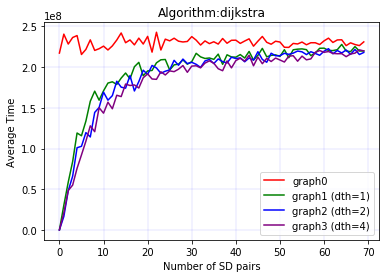

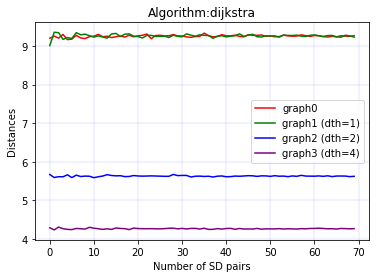

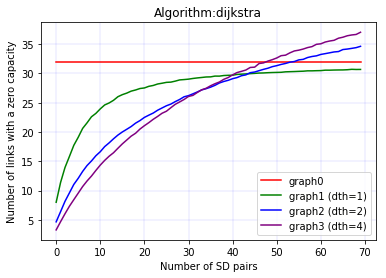

In [11]:
start = time.time()
dijkstra_results = run_algorithm_for_graphs([graph0, graph1, graph2, graph3], number_of_source_destination_pairs, number_of_samples)
write_results_to_file(dijkstra_results, 'dijkstra','', (time.time() - start))

plot_results(dijkstra_results, 'dijkstra')

# Having same number of virtual links (Dijkstra)

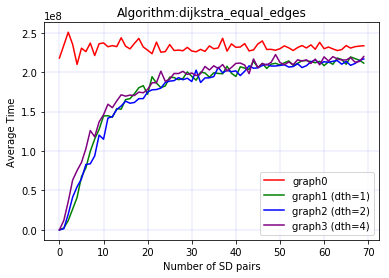

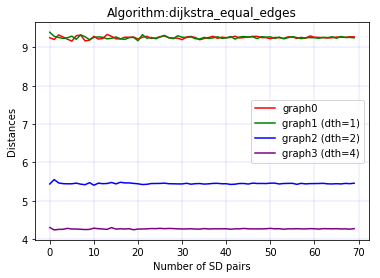

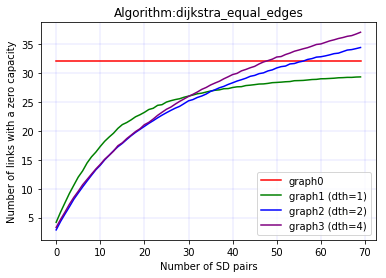

In [12]:
start = time.time()
dijkstra_equal_edges_results = run_algorithm_for_graphs([graph0, graph1_equal_edges, graph2_equal_edges, graph3], number_of_source_destination_pairs, number_of_samples)
write_results_to_file(dijkstra_equal_edges_results, 'dijkstra_equal_edges','', (time.time() - start))

plot_results(dijkstra_equal_edges_results, 'dijkstra_equal_edges')

# Global algorithm

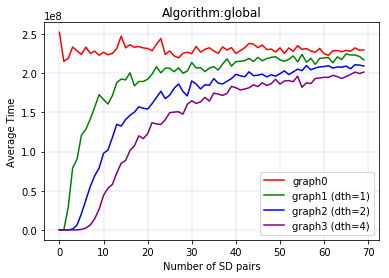

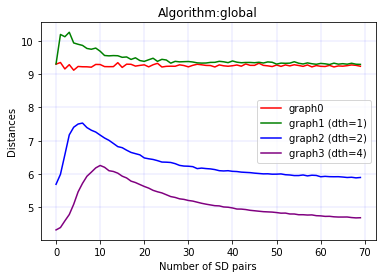

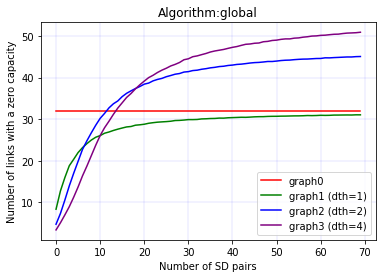

In [18]:
start = time.time()
global_results = run_algorithm_for_graphs([graph0, graph1, graph2, graph3], number_of_source_destination_pairs, number_of_samples, global_algo)
write_results_to_file(global_results, 'global','', (time.time() - start))

plot_results(global_results, 'global')

# Global algorithm (in equal edged graphs)

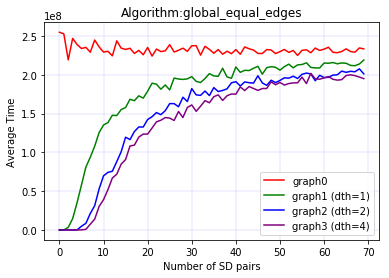

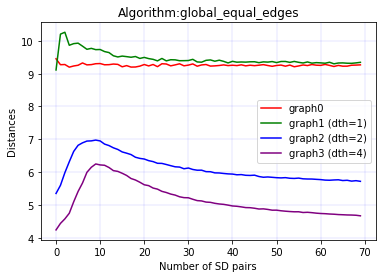

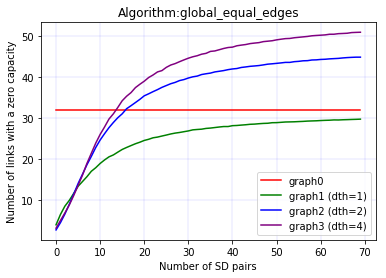

In [19]:
start = time.time()
global_equal_edges_results = run_algorithm_for_graphs([graph0, graph1_equal_edges, graph2_equal_edges, graph3], number_of_source_destination_pairs, number_of_samples, global_algo)
write_results_to_file(global_equal_edges_results, 'global_equal_edges','', (time.time() - start))

plot_results(global_equal_edges_results, 'global_equal_edges')